### Laboratorium 6 - część projektowa

W tej części zajmiesz się wykorzystaniem punktów kluczowych do łączenia obrazów (_image stitching_). Celem zadania jest przetestowanie możliwości detekcji i parowania punktów kluczowych w celu łączenia obrazów. Istotne jest, by samodzielnie przejść całą ścieżkę: od detekcji punktów kluczowych i wyznaczenia ich desktryptorów, przez ich parowanie i znalezienie transformacji, po finalne połączenie obrazów. Rozwiązania oparte o gotowce w stylu black-box nie będą oceniane.

Wykonaj serię zdjęć dowolnej wybranej przez siebie **statycznej** sceny. Może to być niemal dowolny widok o dowolnej skali: panorama miasta, swojego pokoju, powierzchni biurka - ważne, by pozyskane obrazy umożliwiały (1) użycie algorytmu SIFT, oraz (2) wykonanie transformacji geometrycznej.

Wykonaj 4-5 zdjęć, spośród których pierwsze (nazwij je `base`) niech przedstawia \"główny\" widok sceny, a pozostałe (o nazwie `offset_{index}`) niech cechują się coraz większym przesunięciem kamery względem `base`. Proponowane różnice:
* nieznaczne przesunięcie (o ~połowę szerokości klatki),
* większe przesunięcie (o 3/4 szerokości lub więcej),
* przesunięcie z rotacją w osi kamery,
* (jeśli to możliwe) przybliżenie/oddalenie kamery.

Wykorzystaj algorytmy opracowane do realizacji zadania 3 (zwłaszcza 3b) w celu przekształcania obrazów `offset_x` do geometrii `base`. Upewnij się, że wymiary wynikowych obrazów są wystarczające do zmieszczenia obu składowych.

*Czy każdą parę `offset_i`-`base` udało się połączyć? Jeśli dla którejś pary metoda zawiodła, to dlaczego?*  
*Jaka była jakość dopasowania? Na jakiej podstawie ją określasz?*

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def display_img(
    img: np.ndarray,
    title: str,
):
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(title)
    plt.show()

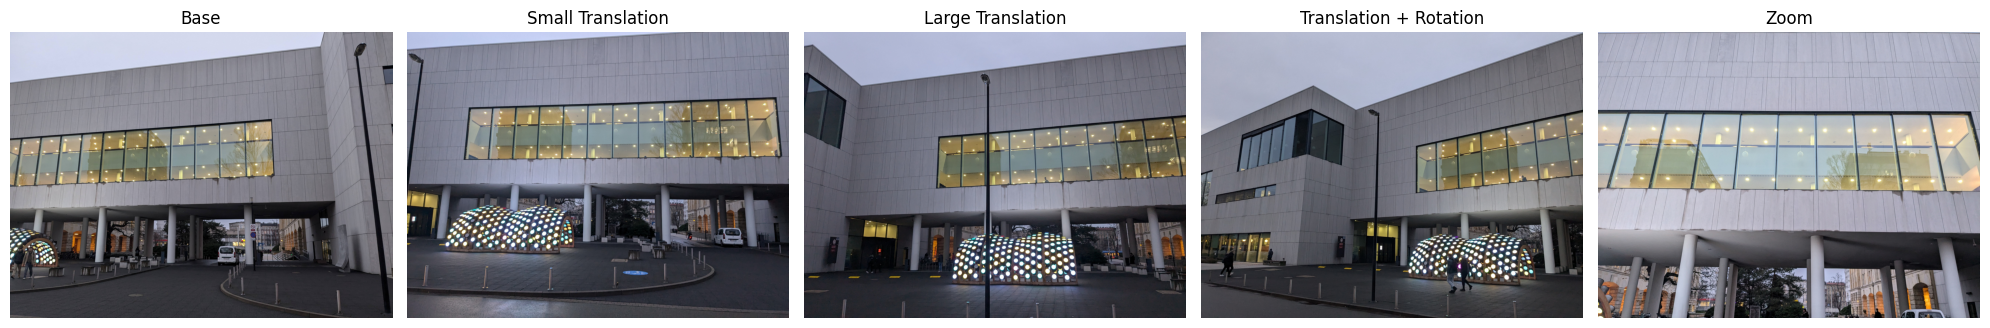

In [3]:
base = cv2.imread("img/1_base.jpg")
trans_1 = cv2.imread("img/2_small_translation.jpg")
trans_2 = cv2.imread("img/3_large_translation.jpg")
trans_and_rot = cv2.imread("img/4_translation_and_rotation.jpg")
zoom = cv2.imread("img/5_zoom.jpg")


fig, axs = plt.subplots(1, 5, figsize=(20, 4))
axs[0].imshow(cv2.cvtColor(base, cv2.COLOR_BGR2RGB))
axs[0].set_title("Base")
axs[0].axis("off")

axs[1].imshow(cv2.cvtColor(trans_1, cv2.COLOR_BGR2RGB))
axs[1].set_title("Small Translation")
axs[1].axis("off")

axs[2].imshow(cv2.cvtColor(trans_2, cv2.COLOR_BGR2RGB))
axs[2].set_title("Large Translation")
axs[2].axis("off")

axs[3].imshow(cv2.cvtColor(trans_and_rot, cv2.COLOR_BGR2RGB))
axs[3].set_title("Translation + Rotation")
axs[3].axis("off")

axs[4].imshow(cv2.cvtColor(zoom, cv2.COLOR_BGR2RGB))
axs[4].set_title("Zoom")
axs[4].axis("off")

plt.tight_layout()
plt.show()

In [4]:
from collections.abc import Sequence


def sift_keys_and_desc(
    image: np.ndarray, contrast_threshold: float, edge_threshold: float
) -> tuple[list[cv2.KeyPoint], np.ndarray]:
    """
    Detect SIFT keypoints and compute descriptors
    Args:
        image: Input image
        contrast_threshold: Contrast threshold for SIFT
        edge_threshold: Edge threshold for SIFT
    Returns:
        Tuple of keypoints and descriptors
    """
    sift = cv2.SIFT_create(
        contrastThreshold=contrast_threshold, edgeThreshold=edge_threshold
    )
    keypoints = sift.detect(image, None)
    return sift.compute(image, keypoints)


def filter_matches(
    matches: Sequence[Sequence[cv2.DMatch]], threshold: float = 0.75
) -> list[cv2.DMatch]:
    """
    Filter matches using Lowe's ratio test
    Args:
        matches: List of matches from knnMatch
        threshold: Threshold for Lowe's ratio test (default 0.75)
    Returns:
        List of good matches that pass the ratio test
    """
    good_matches = []
    for m, n in matches:  # m is best match, n is second best
        if m.distance < threshold * n.distance:
            good_matches.append(m)
    return good_matches


def get_sift_keypoint_img(
    keypoints: list[cv2.KeyPoint],
    image: np.ndarray,
) -> np.ndarray:
    out_img = np.zeros_like(image)
    img_with_kp = cv2.drawKeypoints(
        image,
        keypoints,
        outImage=out_img,
        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS,
    )

    return img_with_kp


def plot_sift_keypoints(
    base_sift: tuple[list[cv2.KeyPoint], np.ndarray],
    contrast_thresh: float,
    edge_thresh: float,
):
    """
    Plot SIFT keypoints
    """
    base_sift_img = get_sift_keypoint_img(base_sift[0], base)
    base_sift_keypoints_len = len(base_sift[0])

    display_img(
        base_sift_img,
        f"Base SIFT, ct={contrast_thresh}"
        + f" edge_threshold={edge_thresh}"
        + f" keypoints={base_sift_keypoints_len}",
    )


def draw_matches(img1, img1_kp, img2, img2_kp, good_matches, threshold):
    match_img = cv2.drawMatches(
        img1,
        img1_kp,
        img2,
        img2_kp,
        good_matches,
        np.zeros_like(img1),
    )

    display_img(
        match_img,
        f"Number of matches: {len(good_matches)}, threshold: {threshold}",
    )


def draw_ransac_matches(
    base_img,
    base_sift,
    overlay_img,
    trans_1_sift,
    good_matches,
    matches_mask,
    threshold,
):
    match_img_ransac = cv2.drawMatches(
        base_img,
        base_sift[0],
        overlay_img,
        trans_1_sift[0],
        good_matches,
        np.zeros_like(base_img),
        matchesMask=matches_mask,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
        matchColor=(0, 255, 0),
    )

    display_img(
        match_img_ransac,
        f"RANSAC: number of matches: {sum(matches_mask)}, threshold: {threshold}",
    )


def get_matching_points(
    source_sift: tuple[list[cv2.KeyPoint], np.ndarray],
    target_sift: tuple[list[cv2.KeyPoint], np.ndarray],
    good_matches: list[cv2.DMatch],
):
    """
    Get matching points from good matches
    """

    src_pts = np.float32(
        [source_sift[0][m.queryIdx].pt for m in good_matches]
    ).reshape(-1, 1, 2)
    dst_pts = np.float32(
        [target_sift[0][m.trainIdx].pt for m in good_matches]
    ).reshape(-1, 1, 2)
    return src_pts, dst_pts

In [5]:
contrast_thresh = 0.04
edge_thresh = 10

trans_2_sift = sift_keys_and_desc(trans_2, contrast_thresh, edge_thresh)
trans_and_rot_sift = sift_keys_and_desc(
    trans_and_rot, contrast_thresh, edge_thresh
)
zoom_sift = sift_keys_and_desc(zoom, contrast_thresh, edge_thresh)

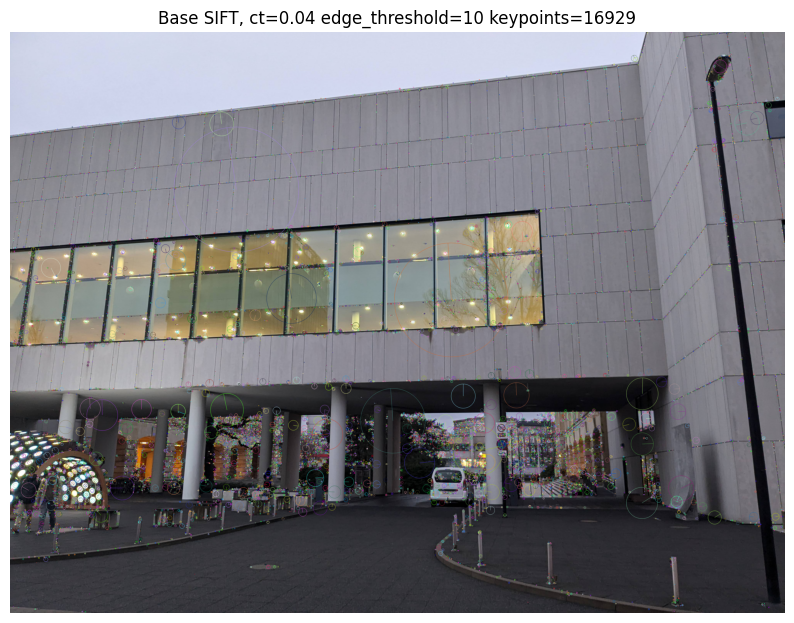

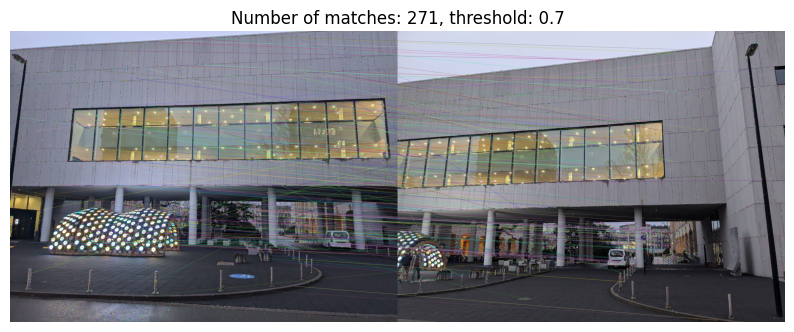

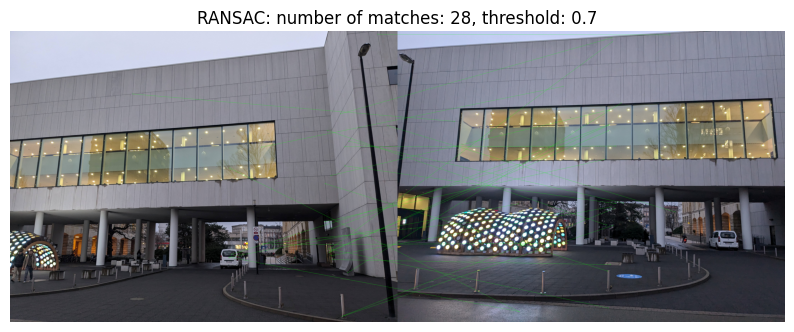

In [6]:
contrast_thresh = 0.04
edge_thresh = 10

base_sift = sift_keys_and_desc(base, contrast_thresh, edge_thresh)
trans_1_sift = sift_keys_and_desc(trans_1, contrast_thresh, edge_thresh)

# display base sift keypoints

plot_sift_keypoints(
    base_sift,
    contrast_thresh,
    edge_thresh,
)
matcher = cv2.BFMatcher()
matches = matcher.knnMatch(trans_1_sift[1], base_sift[1], k=2)


# filter matches using Lowe's ratio test
threshold = 0.7
good_matches = filter_matches(matches, threshold=threshold)
draw_matches(
    trans_1, trans_1_sift[0], base, base_sift[0], good_matches, threshold
)


# get matching points from good matches and find homography matrix using RANSAC
src_pts, dst_pts = get_matching_points(trans_1_sift, base_sift, good_matches)
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
matches_mask = mask.ravel().tolist()

draw_ransac_matches(
    base,
    base_sift,
    trans_1,
    trans_1_sift,
    good_matches,
    matches_mask,
    threshold,
)

In [7]:
print(M)

point = np.array([[0, 0, 1]])
transformed_point = np.dot(M, point.T)
transformed_point = transformed_point / transformed_point[2]
print(f"Transformed point (0,0): {transformed_point[:2].T}")

[[ 8.11751944e-01 -5.89578038e-02 -5.64072183e+02]
 [-4.80443666e-02  8.75644440e-01  4.43041823e+02]
 [-1.50821344e-05 -1.18466443e-05  1.00000000e+00]]
Transformed point (0,0): [[-564.0721833   443.04182285]]


In [8]:
def adjust_transformation_to_base(
    img: np.ndarray, base_size: tuple[int, int], M: np.ndarray
) -> tuple[np.ndarray, tuple[int, int, int, int]]:
    """
    Adjust transformation Matrix to not clip the image and pad to match with base image

    Returns:
        tuple[np.ndarray, tuple[int, int, int, int]]: Adjusted transformation matrix and padding that should be applied to the base image
    """

    # Original image dimensions
    h, w = img.shape[:2]
    base_h, base_w = base_size

    # Define the corners of the original image
    # Convert corners to homogeneous coordinates
    corners = np.array([[0, 0], [w, 0], [w, h], [0, h]], dtype="float32")
    corners_homogeneous = np.array([[x, y, 1] for x, y in corners])

    # Transform the corners using the homography matrix
    transformed_corners = np.dot(M, corners_homogeneous.T).T

    # Normalize the transformed corners
    transformed_corners = (
        transformed_corners / transformed_corners[:, 2][:, np.newaxis]
    )

    # Extract the x and y coordinates
    transformed_corners = transformed_corners[:, :2]

    # Find the bounding box of the transformed corners
    min_x, min_y = np.min(transformed_corners, axis=0)
    max_x, max_y = np.max(transformed_corners, axis=0)

    pad_left = int(max(0, -min_x))
    pad_right = int(max(0, max_x - base_w))
    pad_top = int(max(0, -min_y))
    pad_bottom = int(max(0, max_y - base_h))

    # Adjust the homography matrix to include the translation
    translation_matrix = np.array(
        [[1, 0, pad_left], [0, 1, pad_top], [0, 0, 1]]
    )
    adjusted_M = np.dot(translation_matrix, M)

    return adjusted_M, (pad_left, pad_right, pad_top, pad_bottom)

In [16]:
def find_homography_with_sift(
    base_img: np.ndarray, overlay_img: np.ndarray, verbose=False
) -> np.ndarray:
    contrast_thresh = 0.04
    edge_thresh = 10

    base_sift = sift_keys_and_desc(base_img, contrast_thresh, edge_thresh)
    trans_1_sift = sift_keys_and_desc(overlay_img, contrast_thresh, edge_thresh)

    if verbose:
        plot_sift_keypoints(
            base_sift,
            contrast_thresh,
            edge_thresh,
        )

    matcher = cv2.BFMatcher()
    matches = matcher.knnMatch(trans_1_sift[1], base_sift[1], k=2)

    threshold = 0.7
    good_matches = filter_matches(matches, threshold=threshold)

    if verbose:
        draw_matches(
            overlay_img,
            trans_1_sift[0],
            base_img,
            base_sift[0],
            good_matches,
            threshold,
        )

    src_pts, dst_pts = get_matching_points(
        trans_1_sift, base_sift, good_matches
    )

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    matches_mask = mask.ravel().tolist()

    if verbose:
        draw_ransac_matches(
            base_img,
            base_sift,
            overlay_img,
            trans_1_sift,
            good_matches,
            matches_mask,
            threshold,
        )

    return M


def stitch_images_with_homeography(
    base_img: np.ndarray, overlay_img: np.ndarray, M: np.ndarray, verbose=False
) -> np.ndarray:
    base_size = base_img.shape[:2]

    adjusted_M, padding = adjust_transformation_to_base(
        overlay_img, base_size, M
    )

    new_w = int(base_size[1] + padding[0] + padding[1])
    new_h = int(base_size[0] + padding[2] + padding[3])

    transformed_img = cv2.warpPerspective(
        overlay_img, adjusted_M, (new_w, new_h)
    )

    pad_left, pad_right, pad_top, pad_bottom = padding

    padded_base = cv2.copyMakeBorder(
        base_img, pad_top, pad_bottom, pad_left, pad_right, cv2.BORDER_CONSTANT
    )

    # mask to know where to stitch
    stitch_mask = np.ones_like(base_img, dtype=np.uint8)
    stitch_mask = cv2.warpPerspective(stitch_mask, adjusted_M, (new_w, new_h))

    if verbose:
        display_img(
            stitch_mask * 255,
            "Stitch mask",
        )
        overlayed_img = cv2.addWeighted(
            padded_base, 0.5, transformed_img, 0.5, 0
        )
        display_img(overlayed_img, "Overlayed images")

    out_img = (transformed_img * stitch_mask) + padded_base * (1 - stitch_mask)
    return out_img

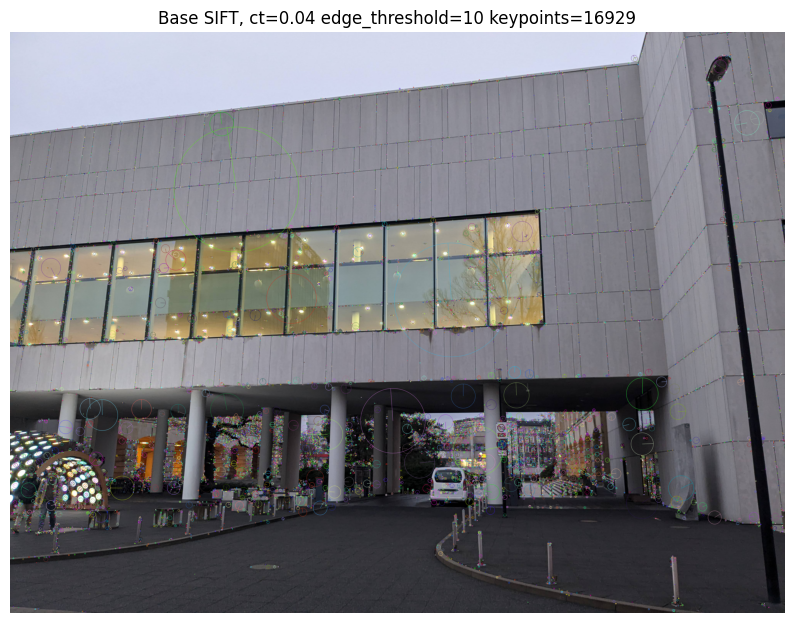

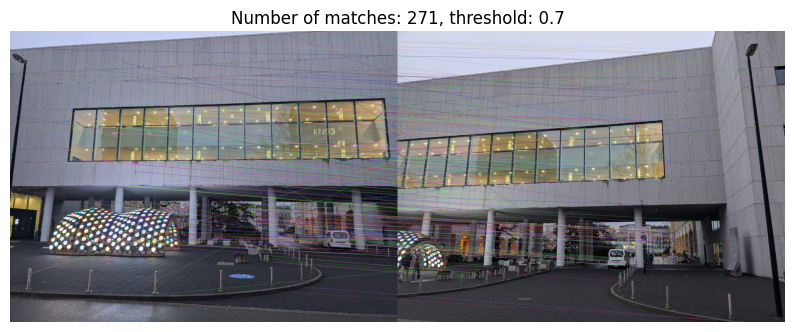

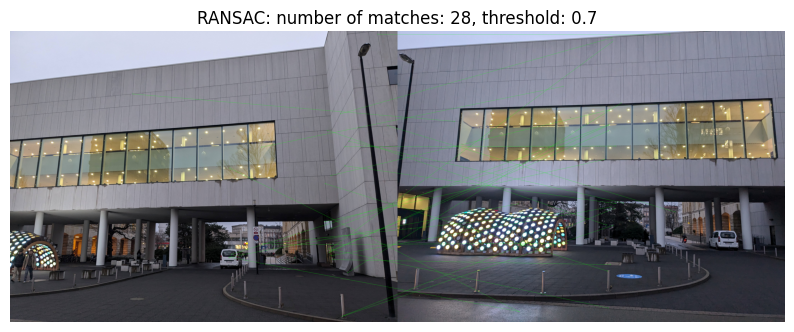

In [17]:
M = find_homography_with_sift(base, trans_1, verbose=True)

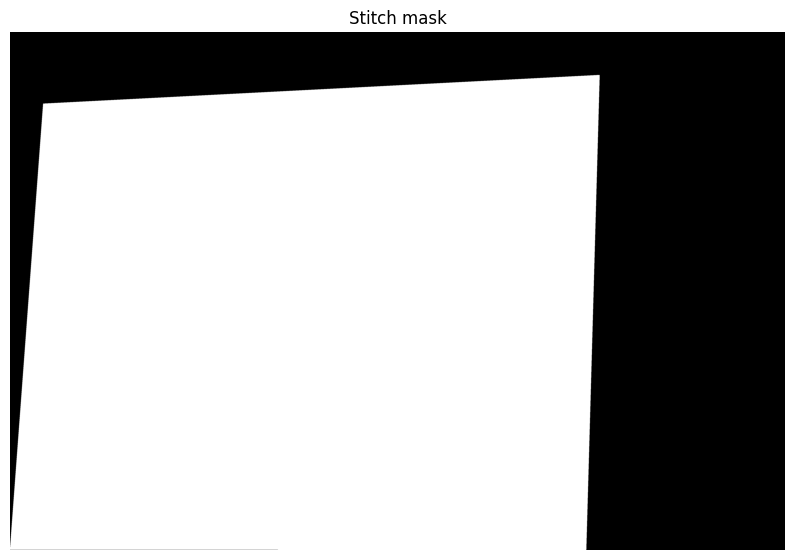

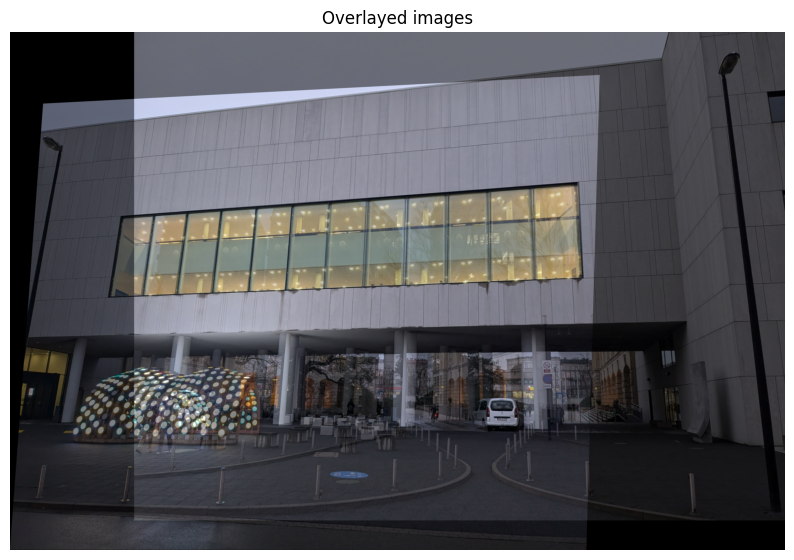

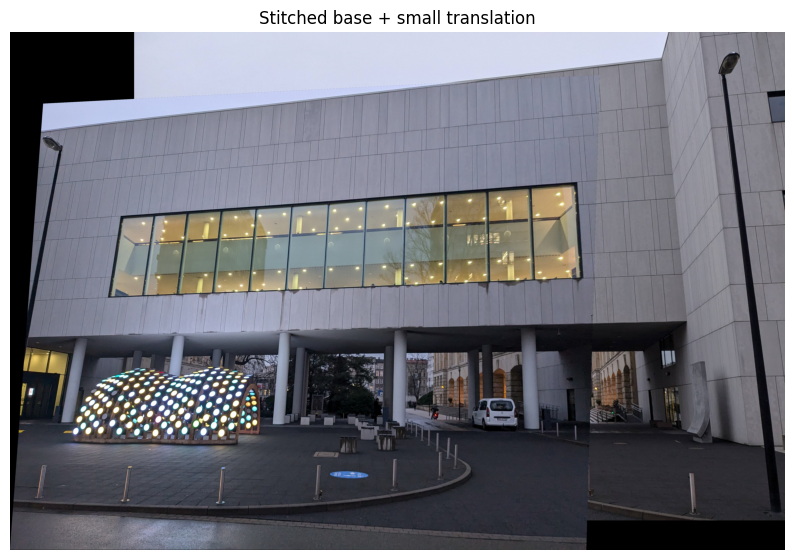

In [18]:
img = stitch_images_with_homeography(base, trans_1, M, verbose=True)


plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Stitched base + small translation")
plt.show()

## Final function for stitching

In [12]:
def stitch_images(base_img: np.ndarray, overlay_img: np.ndarray, verbose=False):
    M = find_homography_with_sift(base_img, overlay_img, verbose)
    img = stitch_images_with_homeography(base_img, overlay_img, M, verbose)

    return img

## Testing final function

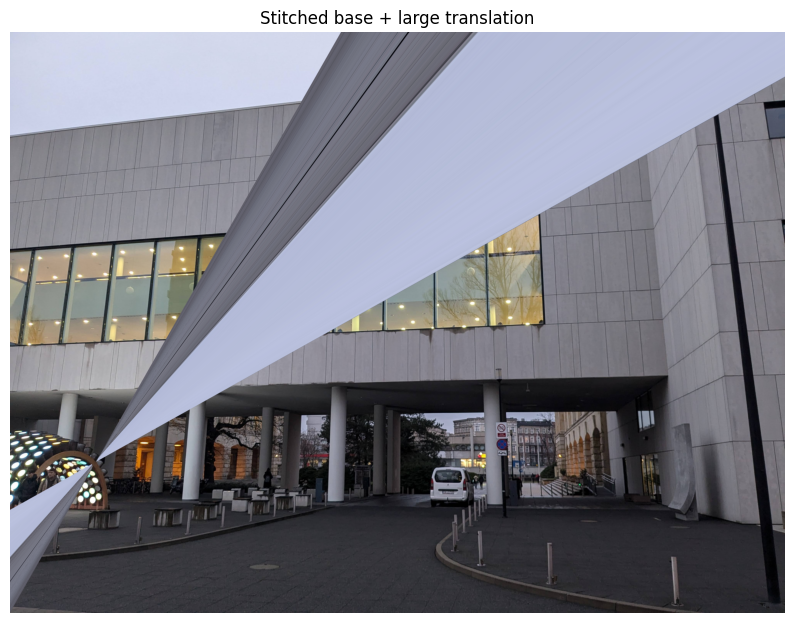

In [13]:
img = stitch_images(base, trans_2)

display_img(img, "Stitched base + large translation")

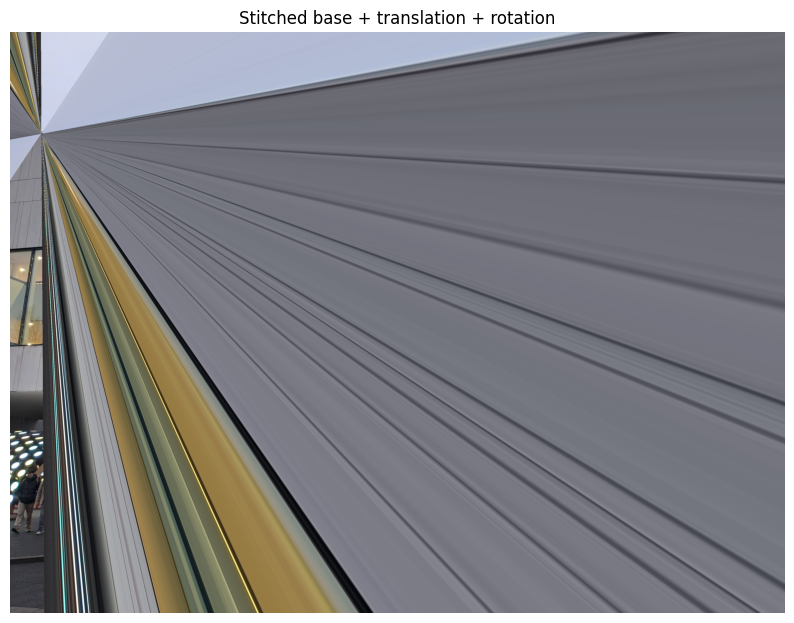

In [14]:
img = stitch_images(base, trans_and_rot)

display_img(img, "Stitched base + translation + rotation")

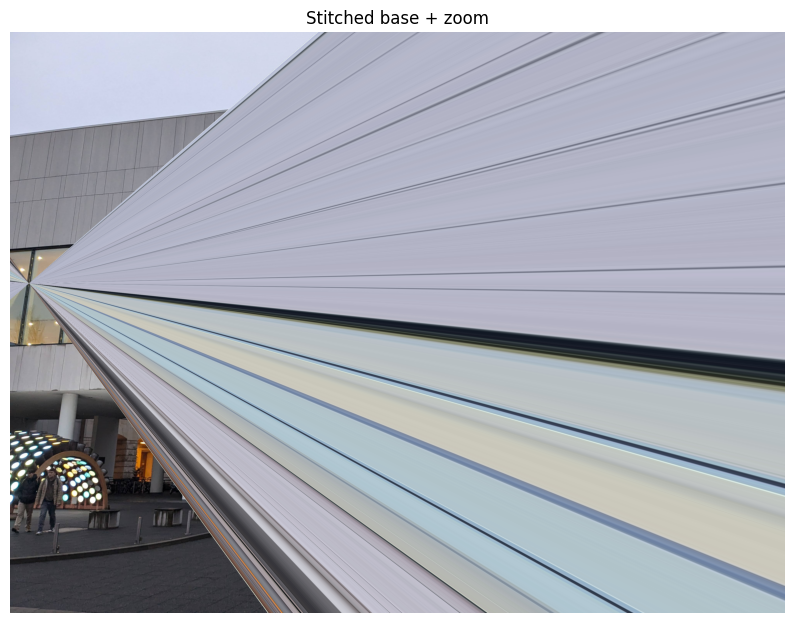

In [15]:
img = stitch_images(base, zoom)
display_img(img, "Stitched base + zoom")